# Tutorial 1

In this notebook we will try to simply augment the size of given training sets using Pyraug's Pipelines.

In [1]:
# If you run this notebook on colab uncomment the following lines
#!pip install pyraug
#!git clone https://github.com/clementchadebec/pyraug.git
#import os
#path=os.path.join(os.getcwd(), 'pyraug/examples')
#os.chdir(path)

## Example 1: MNIST - Training from `numpy.array` or `torch.tensor`

### Data extraction

In [2]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.is_available()

True

#### Extract the data
We only selected 200 samples and display some of the training samples

In [3]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)

In [4]:
n_samples = 200
dataset_to_augment = mnist_trainset.data[:n_samples] 
dataset_to_augment.shape

torch.Size([200, 28, 28])

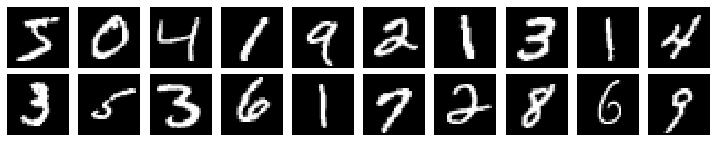

In [5]:
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(2):
        for j in range(10):
                axes[i][j].matshow(dataset_to_augment[i*10 +j].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)
#plt.savefig('plots/training_data_3_rotated_corrupted.pdf')

## Let's augment them !

## Step 1 - Model training

The first thing to do to augment your data is to train a generative model on it. The you will be able to reuse such model to generate as much data as desired to augment your initial data set.

In [6]:
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines.training import TrainingPipeline

Here we define a training configuration that will be passed to the `TrainingPipeline`.

In [7]:
config = TrainingConfig(
    output_dir='my_model',
    train_early_stopping=50,
    learning_rate=1e-3,
    batch_size=200, # Set to 200 for demo purposes to speed up (default: 50)
    max_epochs=500 # Set to 500 for demo purposes. Augment this in your case to access to better generative model (default: 20000)
)

Let's create and launch the Pipeline on our data! You will be able to follow th training evolution in the `output_logs` folder. 

In [8]:
torch.manual_seed(8)

# This creates the Pipeline
pipeline = TrainingPipeline(training_config=config)

# This will launch the Pipeline on the data
pipeline(train_data=dataset_to_augment, log_output_dir='output_logs')

Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Model passed sanity check !

Created my_model/training_2021-09-03_09-08-34. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in my_model/training_2021-09-03_09-08-34/final_model


## Step 2 - Generate new data from your trained model

Next, just reload the model and pass it to the `GenerationPipeline` 

In [9]:
from pyraug.pipelines.generation import GenerationPipeline

In [10]:
from pyraug.models import RHVAE
import os

last_training = sorted(os.listdir('my_model'))[-1]

# reload the model
model = RHVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

Let's create and launch the Pipeline with our model!

In [11]:
torch.manual_seed(88)
torch.cuda.manual_seed(88)

# This creates the Pipeline
generation_pipe = GenerationPipeline(
    model=model
)

# This will launch the Pipeline
generation_pipe(100)

Created dummy_output_dir/generation_2021-09-03_09-09-25.Generated data and sampler config will be saved here.

Generation successfully launched !



## Step 3 - Retrieve the generated data

In [12]:
last_generation = sorted(os.listdir('dummy_output_dir'))[-1]
generated_data = torch.load(os.path.join('dummy_output_dir', last_generation, 'generated_data_100_0.pt'))

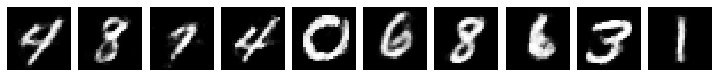

In [13]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
        
                axes[i].matshow(generated_data[i].cpu().reshape(28, 28).numpy(), cmap='gray')
                axes[i].axis('off')

plt.tight_layout(pad=0.8)

Here the model may need more training. We deliberatly stop training after 200 epochs. To see better performances, try augmentating the `max_epochs` argument of the `TrainingConfig`.

## Example 2: Custom data - Training from folder

Likewise, you can train a generative model from a folder where each file is a data.

**note**: Here we deliberatly chose to select images of different shapes. Hence, they will be preprocessed and reshaped in the `TrainingPipeline`

In [14]:
from PIL import Image

path_to_images = '_demo_data/imgs/'

Let's have a look to the images in this folder

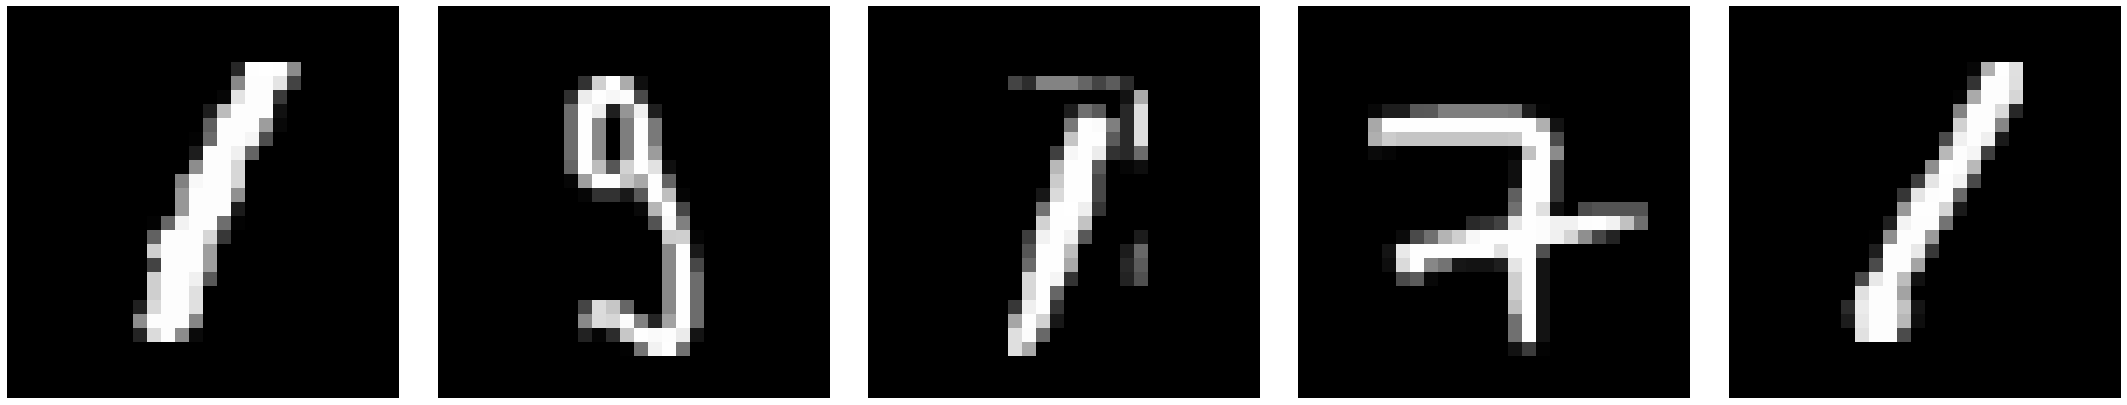

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(30, 30))
plt.tight_layout(pad=0.8)


for (i, im_path) in enumerate(os.listdir(path_to_images)[:5]):
    im = np.array(Image.open(os.path.join(path_to_images, im_path))) # these are 3 channels images
    axes[i].imshow(im)
    axes[i].axis('off')

## Let's train a model ...

In [16]:
config = TrainingConfig(
    output_dir='my_model',
    train_early_stopping=50,
    learning_rate=1e-4, # Since data is of high dimension decrease the learning rate to avoid nan 
    batch_size=200, # Set to 200 for demo purposes to speed up (default: 50)
    max_epochs=500 # Set to 200 for demo purposes. Augment this in your case (default: 20000)
)

In [17]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)

# Create the Pipeline
pipeline = TrainingPipeline(training_config=config)

# Launch the Pipeline on data coming from a folder
pipeline(train_data=path_to_images, log_output_dir='output_logs')

Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Model passed sanity check !

Created my_model/training_2021-09-03_09-09-37. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in my_model/training_2021-09-03_09-09-37/final_model


## ... and generate new data

In [18]:
from pyraug.models import RHVAE

last_training = sorted(os.listdir('my_model'))[-1]
model = RHVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [19]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)


generation_pipe = GenerationPipeline(
    model=model,
)
generation_pipe(5)

Created dummy_output_dir/generation_2021-09-03_09-10-36.Generated data and sampler config will be saved here.

Generation successfully launched !



In [20]:
last_generation = sorted(os.listdir('dummy_output_dir'))[-1]
generated_data = torch.load(os.path.join('dummy_output_dir', last_generation, 'generated_data_5_0.pt'))

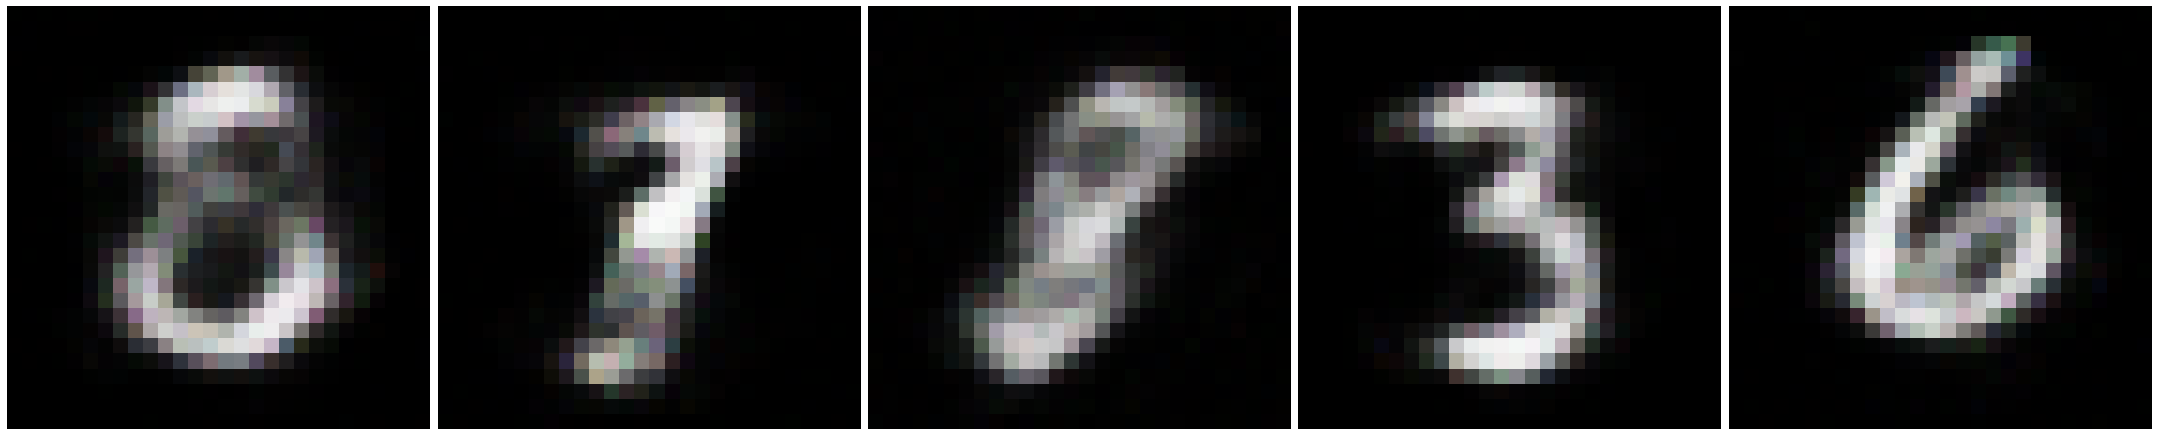

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(30, 30))
im_n = 0
for i in range(1):
        for j in range(5):
                axes[j].matshow(np.moveaxis(generated_data[i*5 +j].cpu().reshape(3, 28, 28).numpy(), 0, 2), cmap='gray')
                axes[j].axis('off')

plt.tight_layout(pad=0.8)

Check that they are not all the same

In [22]:
for i in range(len(generated_data)):
    for j in range(i+1, len(generated_data)):
        assert not torch.equal(generated_data[j].cpu(), torch.tensor(generated_data[i]).cpu().type(torch.float)), (i, j)

<ipython-input-22-e8c52415bc02>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert not torch.equal(generated_data[j].cpu(), torch.tensor(generated_data[i]).cpu().type(torch.float)), (i, j)


## Conclusion

Of course in this tutorial models must have be trained a bit more to be able to generate more realistic samples. We only train them for a few epoch to give you a flavour of Pyraug works. Morevoer, the neural networks used on the default one and more optimized networks may be welcomed. Have a look to tutorial 'making_your_own_autoencoder.ipynb' to see how to amend these networks.